<a href="https://colab.research.google.com/github/chelynl/Machine_Learning/blob/main/ML_Explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning Explainability**

### Overview
1. Use Cases for Model Insights
2. Permutation Importance
3. Partial Plots
4. SHAP Values
5. Advanced Uses of SHAP Values

Interpretations can be `"local"` or `"global"`:
- **Local** = behavior of relationship around a specific point
 - ex/ When x=10, y decreases as x increases
- **Global** = general trend around entire input data space
 - ex/ As x increases y tends to increase

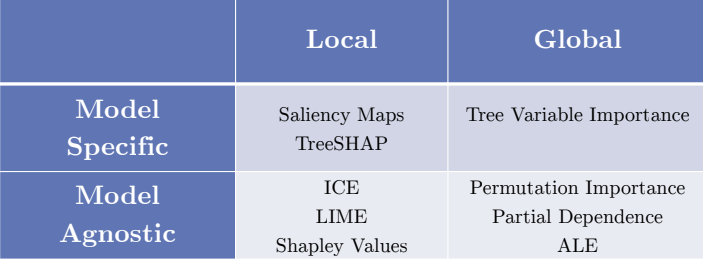

***

## **Use Cases for Model Insights**

<u>Insights you can extract from ML models</u>
- Feature importance
- For any single prediction from a model, how did each feature in the data affect that particular prediction?
- How does each feature affect the model's predictions in a big-picture sense (what is its typical effect when considered over a large number of possible predictions)?

<u>Why are these insights valuable?</u>
- Debugging
 - insights can point out odd behavior in patterns to find source of errors
- Informing feature engineering
 - you can combine features to get a "golden feature" when given many features to choose from
- Directing future data collection
 - insights give a good understanding of current feature values, which can help determine new important features
- Informing human decision-making
 - insights can be more valuable than predictions for making these decisions
- Building Trust
 - showing relevant insights to the problem will help gain trust with clients
- Fairness / Transparency
- Model robustness and integrity
- Adverse Action notice requirements (ECOA, FCRA, etc.)

***

## **Permutation Importance**

One of multiple ways to measure feature importance, permutation importance is:
- fast to calculate
- widely used and understood
- consistent with properties we would want a feature importnace measure to have

Permutation importance is calculated AFTER a model has been fitted. <br>
Ask yourself: `"If I randomly shuffle a single column of the validation data, leaving the target and all other columns in place, how would that affect the accuracy of predictions in that now-shuffled data?"`

*If that column (feature) is important, the model should perform worse when that feature is destroyed (randomly shuffled) in the model.*

### Process
1. Get a trained model.
2. Shuffle the values in a single column, make predictions using the resulting dataset. Use these predictions and the true target values to calculate how much the loss function suffered from shuffling. That performance deterioration measures the importance of the variable you just shuffled.
3. Return the data to the original order (undoing the shuffle from step 2). Now repeat step 2 with the next column in the dataset, until you have calculated the importance of each column.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

Predict whether a team would have a player win the Man of the Match award.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML concepts/ML Insights/FIFA 2018 Statistics.csv')
data.head()

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,3,11,0,78,306,118,22,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,60,6,0,3,3,2,1,25,2,86,511,105,10,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN
2,15-06-2018,Egypt,Uruguay,0,43,8,3,3,2,0,1,7,3,78,395,112,12,2,0,0,No,NaN,Group Stage,No,0,NaN,NaN
3,15-06-2018,Uruguay,Egypt,1,57,14,4,6,4,5,1,13,3,86,589,111,6,0,0,0,Yes,89.0,Group Stage,No,0,NaN,NaN
4,15-06-2018,Morocco,Iran,0,64,13,3,6,4,5,0,14,2,86,433,101,22,1,0,0,No,NaN,Group Stage,No,0,1.0,90.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    128 non-null    object 
 1   Team                    128 non-null    object 
 2   Opponent                128 non-null    object 
 3   Goal Scored             128 non-null    int64  
 4   Ball Possession %       128 non-null    int64  
 5   Attempts                128 non-null    int64  
 6   On-Target               128 non-null    int64  
 7   Off-Target              128 non-null    int64  
 8   Blocked                 128 non-null    int64  
 9   Corners                 128 non-null    int64  
 10  Offsides                128 non-null    int64  
 11  Free Kicks              128 non-null    int64  
 12  Saves                   128 non-null    int64  
 13  Pass Accuracy %         128 non-null    int64  
 14  Passes                  128 non-null    in

In [ ]:
# Drop cols with NA
data.dropna(axis=1, inplace=True)

In [ ]:
# Convert target from string "Yes"/"No" to binary values
y = (data['Man of the Match'] == "Yes")

# Get numeric feature names
feature_names = data.select_dtypes(np.number).columns
# Define input features
X = data[feature_names]

# Partition data
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=1)

# Instantiate model and fit to training data
clf = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)

Calculate and show importances with eli5 library

In [ ]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

     |████████████████████████████████| 112kB 30.4MB/s 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# Instantiate permutation importance tool and fit to validation data
perm = PermutationImportance(clf, random_state=1).fit(X_val, y_val)
# See feature importance scores (top = most important, bottom = least important)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())

Weight,Feature
0.1750 ± 0.0848,Goal Scored
0.0500 ± 0.0637,Distance Covered (Kms)
0.0437 ± 0.0637,Yellow Card
0.0187 ± 0.0500,Off-Target
0.0187 ± 0.0637,Free Kicks
0.0187 ± 0.0637,Fouls Committed
0.0125 ± 0.0637,Pass Accuracy %
0.0125 ± 0.0306,Blocked
0.0063 ± 0.0612,Saves
0.0063 ± 0.0250,Ball Possession %


### How to read this
`[amount model performance decreased with random shuffling] ± [amount performance varied from one re-shuffling to the next]`

We used accuracy as the performance metric. Negative values mean that the randomly shuffled dataset performed better than the original dataset by chance(clear sign that the feature does not matter in actual predictions).

In this example, the most important feature is `'Goal Scored'`, which makes sense for predicting `'Man of the Match'`.

### Taxi Fare Example

In [ ]:
# load dependencies
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML concepts/ML Insights/NYC_train.csv', nrows=50000)
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [ ]:
# Remove data with extreme outlier coordinates or negative fares
df = df.query('pickup_latitude > 40.7 and pickup_latitude < 40.8 and ' +
                  'dropoff_latitude > 40.7 and dropoff_latitude < 40.8 and ' +
                  'pickup_longitude > -74 and pickup_longitude < -73.9 and ' +
                  'dropoff_longitude > -74 and dropoff_longitude < -73.9 and ' +
                  'fare_amount > 0'
                  )

# Features to use in model
base_features = ['pickup_longitude',
                 'pickup_latitude',
                 'dropoff_longitude',
                 'dropoff_latitude',
                 'passenger_count']

# Define target and inputs
y = df.fare_amount
X = df[base_features]

# Partition data
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=1)
first_model = RandomForestRegressor(n_estimators=50, random_state=1).fit(X_train, y_train)

In [ ]:
X_train.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,23466.000000,23466.000000,23466.000000,23466.000000,23466.000000
mean,-73.976827,40.756931,-73.975359,40.757434,1.662320
std,0.014625,0.018206,0.015930,0.018659,1.290729
min,-73.999999,40.700013,-73.999999,40.700020,0.000000
25%,-73.987964,40.744901,-73.987143,40.745756,1.000000
50%,-73.979629,40.758076,-73.978588,40.758542,1.000000
75%,-73.967797,40.769602,-73.966459,40.770406,2.000000
max,-73.900062,40.799952,-73.900062,40.799999,6.000000


In [ ]:
y_train.describe()

count    23466.000000
mean         8.472539
std          4.609747
min          0.010000
25%          5.500000
50%          7.500000
75%         10.100000
max        165.000000
Name: fare_amount, dtype: float64

From using the raw data and intuition, we would expect all features except number of passengers to be important for predicting taxi fares.

In [ ]:
# Create permutation object and fit to validation data
perm = PermutationImportance(first_model, random_state=1).fit(X_val, y_val)

# See results
eli5.show_weights(perm, feature_names=X_val.columns.tolist())

Weight,Feature
0.8387 ± 0.0168,dropoff_latitude
0.8326 ± 0.0212,pickup_latitude
0.5947 ± 0.0432,pickup_longitude
0.5326 ± 0.0275,dropoff_longitude
-0.0022 ± 0.0014,passenger_count


The 4 directional features are important but, on average, the *latitude* features are more important than the *longitude* features. 

<u>Possible explanations</u>
1. Travel might tend to have greater latitude distances than longitude distances. If the longitudes values were generally closer together, shuffling them wouldn't matter as much. 
2. Different parts of the city might have different pricing rules (e.g. price per mile), and pricing rules could vary more by latitude than longitude. 
3. Tolls might be greater on roads going North<->South (changing latitude) than on roads going East <-> West (changing longitude). Thus latitude would have a larger effect on the prediction because it captures the amount of the tolls.

With this insight, we can create **new features** for longitudinal and latitudinal distance.

In [ ]:
# Create distance between pickup and dropoff coordinates
df['abs_lon_change'] = abs(df.dropoff_longitude - df.pickup_longitude)
df['abs_lat_change'] = abs(df.dropoff_latitude - df.pickup_latitude)

# New set of features to use in model
features_2  = ['pickup_longitude',
               'pickup_latitude',
               'dropoff_longitude',
               'dropoff_latitude',
               'abs_lat_change',
               'abs_lon_change']
# New input data
X = df[features_2]

# Partition data and train model
X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X, y, random_state=1)
second_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(X_train_new, y_train_new)

In [ ]:
# See permutation importance scores
perm2 = PermutationImportance(second_model, random_state=1).fit(X_val_new, y_val_new)
eli5.show_weights(perm2, feature_names=X_val_new.columns.tolist())

Weight,Feature
0.5786 ± 0.0294,abs_lat_change
0.4469 ± 0.0509,abs_lon_change
0.0860 ± 0.0334,pickup_latitude
0.0735 ± 0.0114,dropoff_latitude
0.0735 ± 0.0101,dropoff_longitude
0.0609 ± 0.0067,pickup_longitude


In [ ]:
X_train_new.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,abs_lat_change,abs_lon_change
37925,-73.998695,40.726192,-73.977974,40.730652,0.004459,0.020721
21594,-73.985115,40.756692,-73.985735,40.744192,0.012500,0.000620
39549,-73.961988,40.776092,-73.974067,40.783107,0.007015,0.012079
11953,-73.953661,40.766884,-73.948705,40.773745,0.006861,0.004956
5521,-73.957168,40.765680,-73.969532,40.758050,0.007630,0.012364


We can see that the `'abs_lat_change'` and `'abs_lon_change'` values are very small compared to the other variables. However, scale of features does not affect permutation importance in this case because we are using a tree-based model (not sensitive to data variance). Rescaling features would affect PI if rescaling affects the ability of a particular ML model (such as KNN, K-means, etc.).

We cannot tell from the permutation importance results whether traveling a fixed latitudinal distance is more or less expensive than traveling the same longitudinal distance. 

<u>Possible reasons latitude feature are more important than longitude features</u>
1. latitudinal distances in the dataset tend to be larger 
2. it is more expensive to travel a fixed latitudinal distance 
3. Both of the above If abs_lon_change values were very small, longitues could be less important to the model even if the cost per mile of travel in that direction were high.

***

## **Partial Dependence Plots**
While feature importance shows what variables most affect predictions, partial dependence plots show **how a feature affects predictions**.
- attempts to show the *marginal effect* of inputs on the target (global)
- the *expectation* (mean/avg) of our predictive model across values of a single variable X
- calculated AFTER model has been fit on raw data
- shows how a variable is nonlinear

### Process
1. Choose a variable-of-interest.
2. Replicate your dataset, holding all values constant except the variable-of-interest.
3. Fill in values for variable-of-interest for each replicated dataset across the range of the variable.
4. Use the model to generate predictions for this simulated data.
5. Average the predictions for each replicated dataset.

Considering a single row at a time, use the fitted model to predict the outcome (probability their player won "man of the match"). But we repeatedly alter the value for one variable (range of variable) to make a series of predictions.

Interactions between features may cause the plot for a single row to be atypical. So, we repeat that mental experiment with multiple rows from the original dataset, and we plot the average predicted outcome on the vertical axis.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Soccer dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML concepts/ML Insights/FIFA 2018 Statistics.csv')
y = (data['Man of the Match'] == "Yes") # Convert from string "Yes"/"No" to binary

# Get numeric feature names
feature_names = data.select_dtypes(np.number).columns
# Define input features
X = data[feature_names]

# Partition data
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(X_train, y_train)

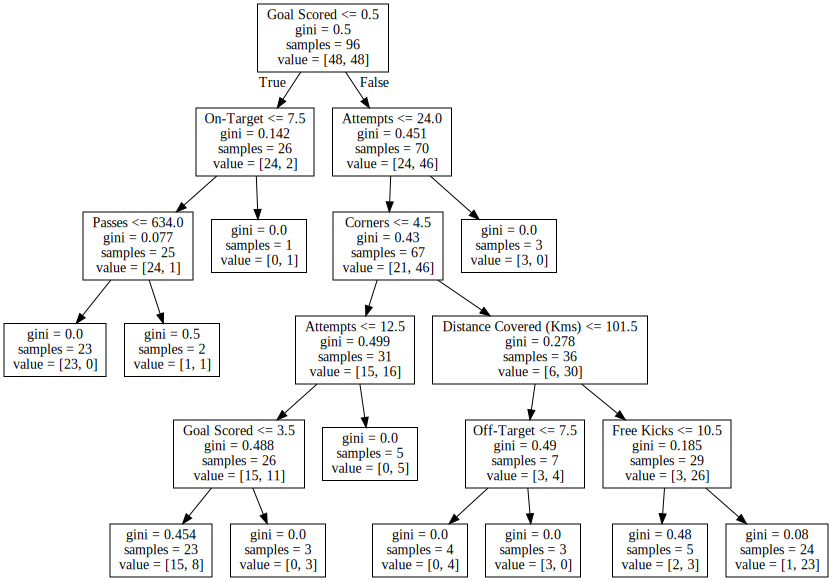

In [ ]:
from sklearn import tree
import graphviz

# Visualize tree
tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=feature_names)
graphviz.Source(tree_graph)

In [ ]:
# Create partial dependence plot
from matplotlib import pyplot as plt
!pip install pdpbox
from pdpbox import pdp, get_dataset, info_plots

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


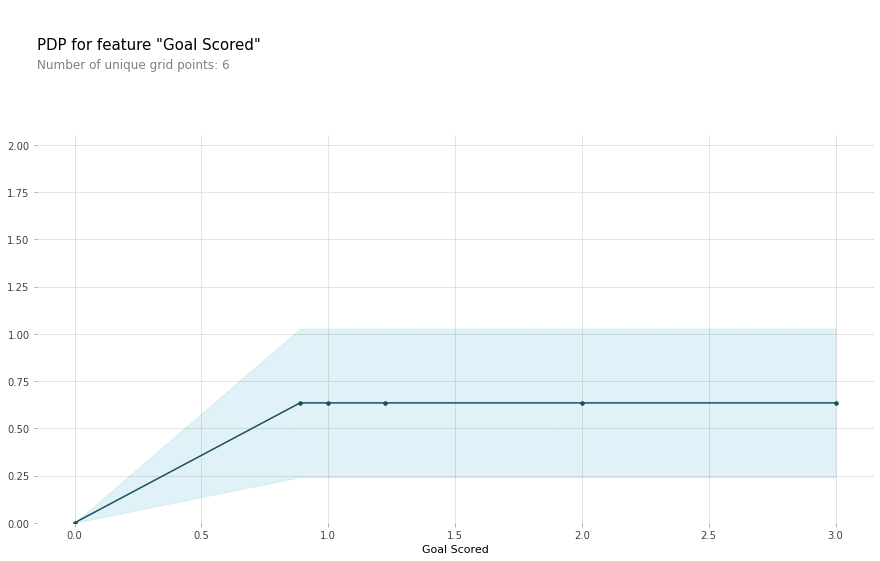

In [ ]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=X_val, model_features=feature_names, feature='Goal Scored')

# plot it
pdp.pdp_plot(pdp_goals, 'Goal Scored')
plt.show()

How to interpret the plot:
- y axis = *change in the prediction* from what it would be predicted at the baseline or leftmost value
- blue shaded area = confidence level


From this particular graph, we see that scoring a goal substantially increases your chances of winning "Man of The Match." But extra goals beyond that appear to have little impact on predictions.

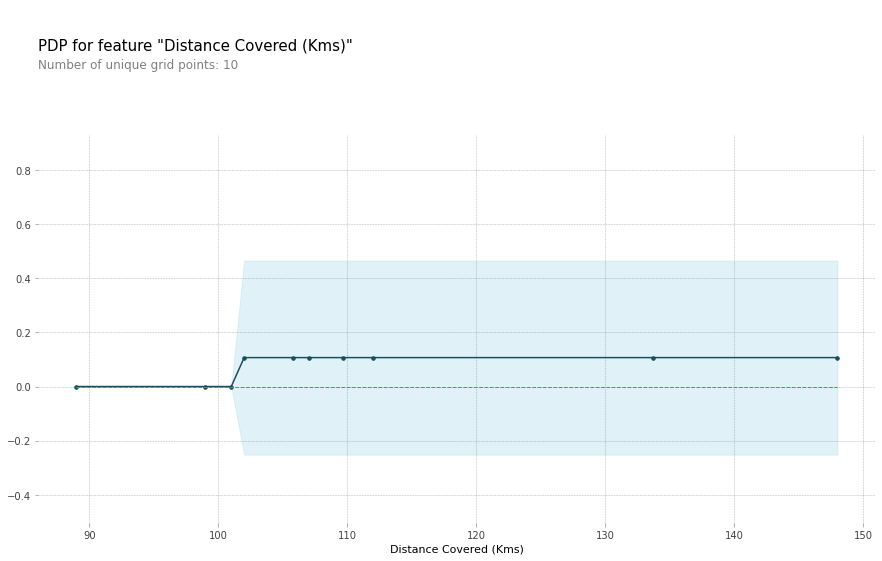

In [ ]:
# PDP for Distance Covered
feature_to_plot = 'Distance Covered (Kms)'
pdp_dist = pdp.pdp_isolate(model=tree_model, dataset=X_val, model_features=feature_names, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

You should be able to see from the decision tree above that this is representing exactly the model's structure. Distance greater than 100km over the course of the game increases your chances of winning "Man of the Match" but little to no impact on predictions after that.

Compare the structure/implications of different models.

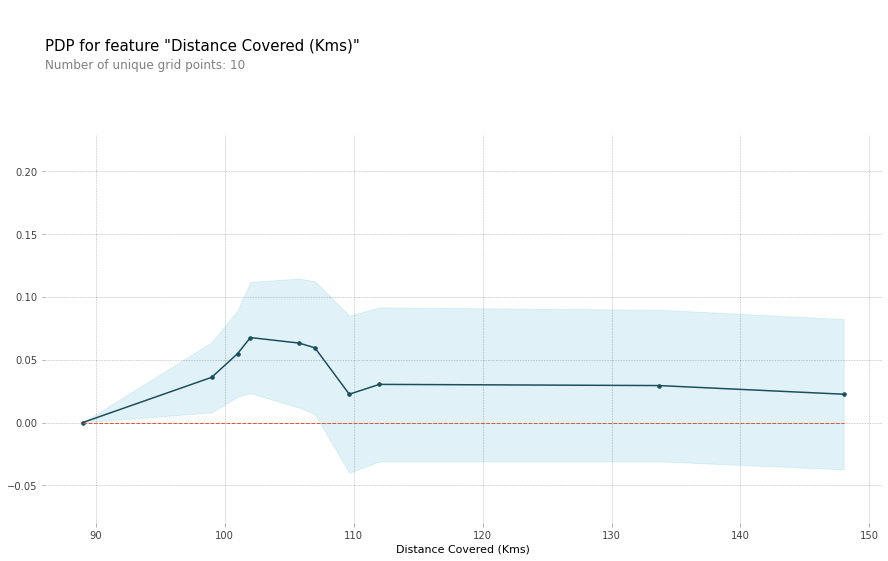

In [ ]:
# Same plot with a random forest model
rf_model = RandomForestClassifier(random_state=0).fit(X_train, y_train)

pdp_dist = pdp.pdp_isolate(model=rf_model, dataset=X_val, model_features=feature_names, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

The model thinks you are more likely to win "Man of the Match" if players run a total of 100km over the course of the game but running more causes lower predictions.

To explore potential interactions between features, **2D partial dependence plots** are useful!

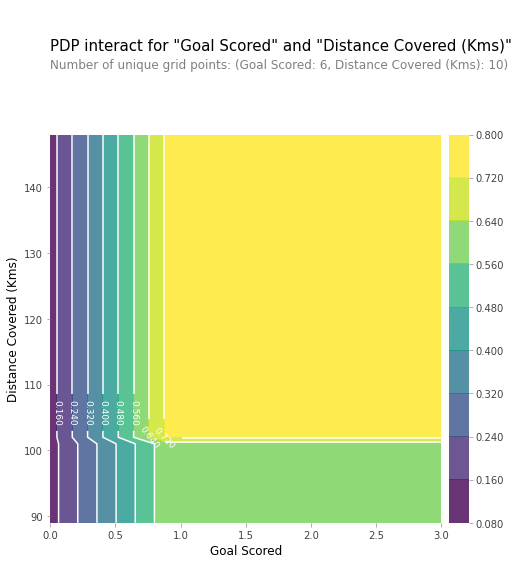

In [ ]:
# Similar to previous PDP plot except we use pdp_interact and pdp_interact_plot instead of pdp_isolate and pdp_isolate_plot
features_to_plot = ['Goal Scored', 'Distance Covered (Kms)']
inter1  =  pdp.pdp_interact(model=tree_model, dataset=X_val, model_features=feature_names, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

This graph shows predictions for any combination of Goals Scored and Distance covered.

For example, we see the highest predictions when a team scores at least 1 goal and they run a total distance close to 100km. If they score 0 goals, distance covered doesn't matter.

But distance can impact predictions if they score goals. Make sure you can see this from the 2D partial dependence plot.

### Taxi Fare Example

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML concepts/ML Insights/NYC_train.csv', nrows=50000)

# Remove data with extreme outlier coordinates or negative fares
df = df.query('pickup_latitude > 40.7 and pickup_latitude < 40.8 and ' +
                  'dropoff_latitude > 40.7 and dropoff_latitude < 40.8 and ' +
                  'pickup_longitude > -74 and pickup_longitude < -73.9 and ' +
                  'dropoff_longitude > -74 and dropoff_longitude < -73.9 and ' +
                  'fare_amount > 0'
                  )

# Features to use in model
base_features = ['pickup_longitude',
                 'pickup_latitude',
                 'dropoff_longitude',
                 'dropoff_latitude']

# Define target and inputs
y = df.fare_amount
X = df[base_features]

# Partition data
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=1)
first_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(X_train, y_train)

print("Data sample:")
df.head()

Data sample:


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1


Plot PDP for `'pickup_longitude'`.

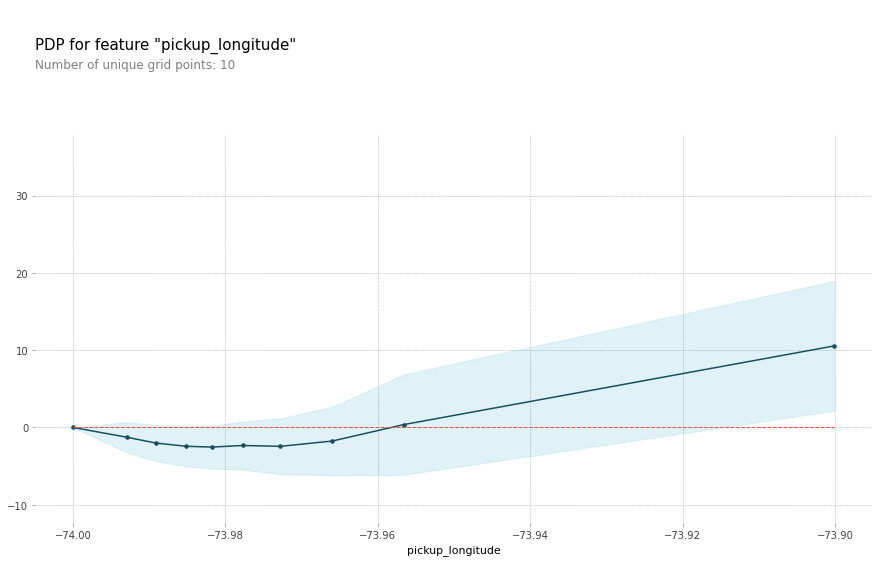

In [ ]:
# Variable-of-interest
feat_name = 'pickup_longitude'

# Instaniate object (data) that we will plot with specified variable-of-interest
pdp_dist = pdp.pdp_isolate(model=first_model, dataset=X_val, model_features=base_features, feature=feat_name)

# Plot object
pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

Being picked up near the center of the longitude values lowers predicted fares on average, because it means shorter trips (on average).

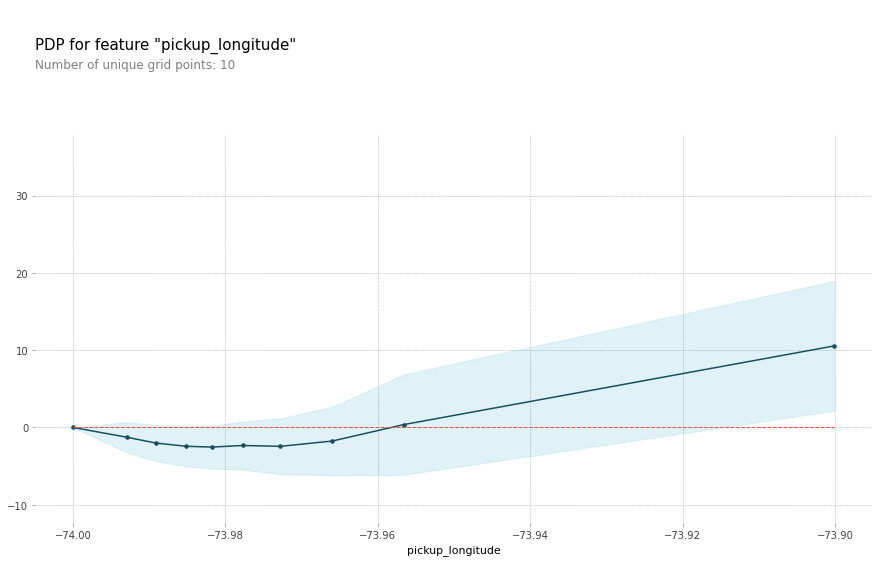

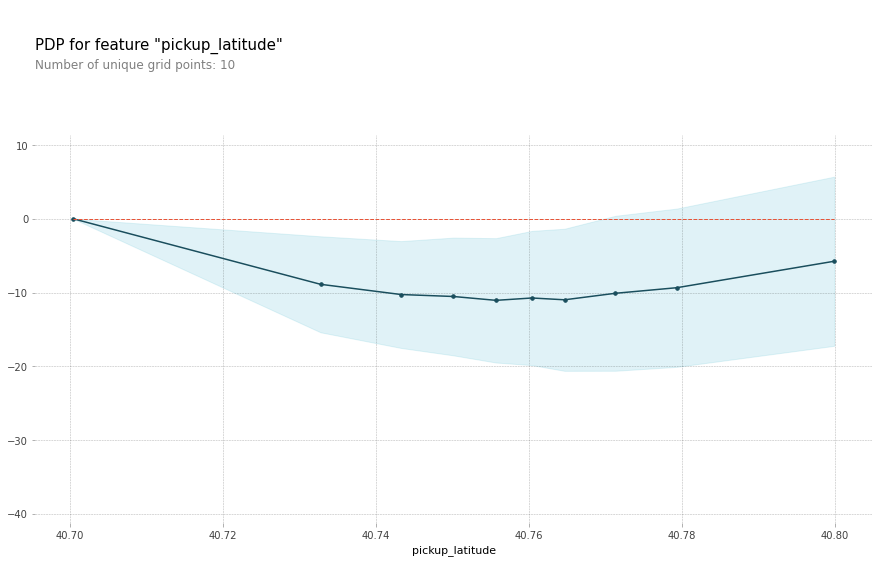

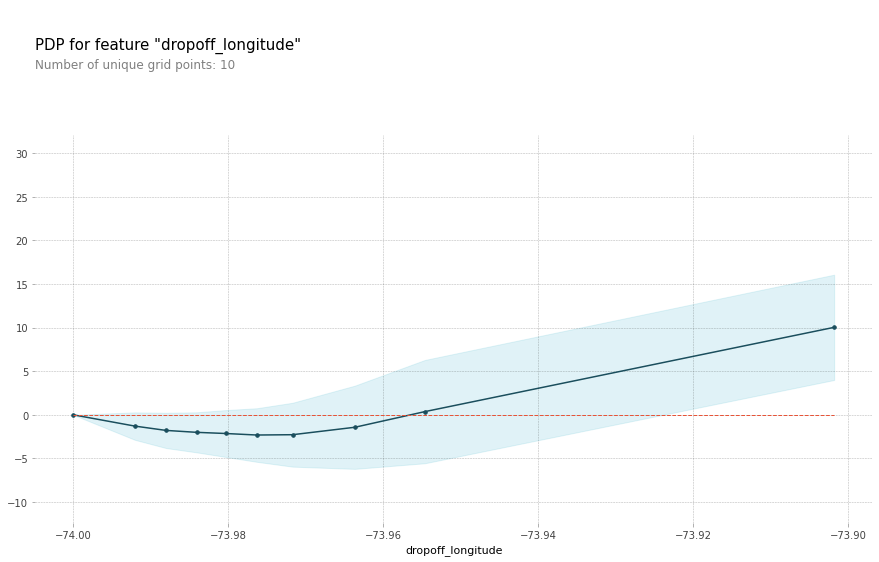

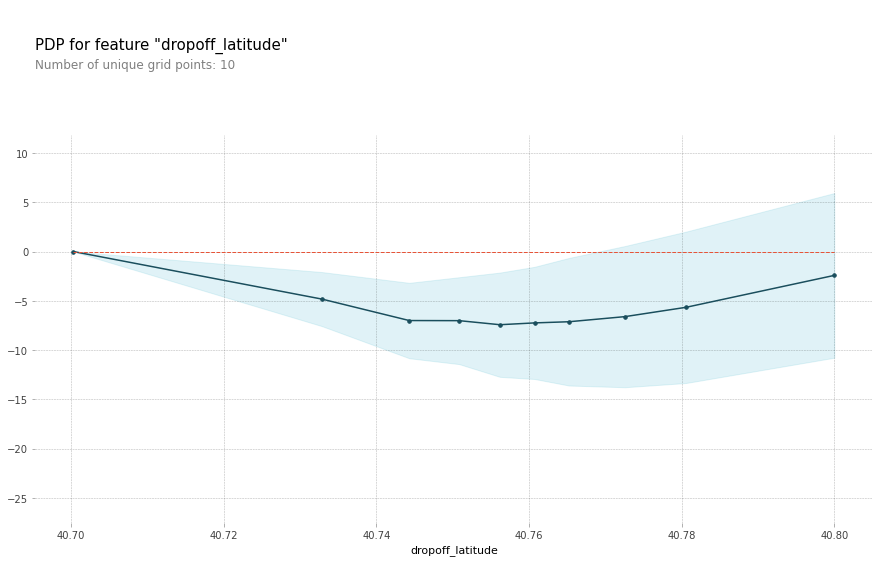

In [ ]:
# All partial plots
for feat_name in base_features:
    pdp_dist = pdp.pdp_isolate(model=first_model, dataset=X_val, model_features=base_features, feature=feat_name)
    pdp.pdp_plot(pdp_dist, feat_name)
    plt.show()

For the same reason, we see the general U-shape in all our partial dependence plots.

Create a 2D plot for the features `pickup_longitude` and `dropoff_longitude`. 

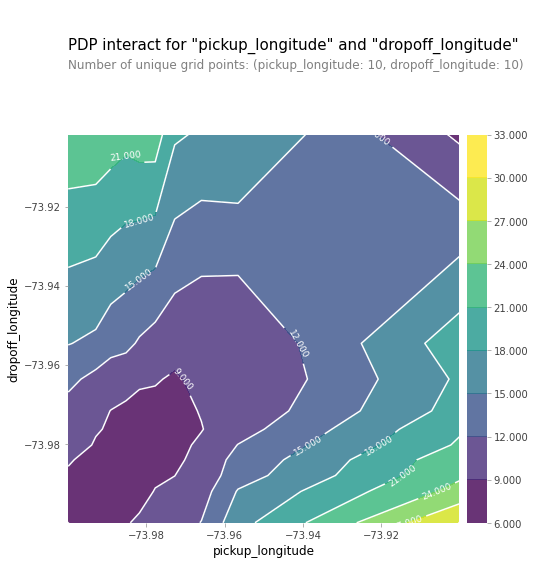

In [ ]:
# Variables-of-interest
features_to_plot = ['pickup_longitude', 'dropoff_longitude']

# Instantiate object to plot with specified interaction
inter1  =  pdp.pdp_interact(model=first_model, dataset=X_val, model_features=base_features, features=features_to_plot)

# Plot object
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

The plot has contours running along a diagonal as we would expect. However, there are interesting caveats.

We expect the diagonal contours because these are pairs of values where the pickup and dropoff longitudes are nearby, indicating shorter trips (controlling for other factors).

As you get further from the central diagonal, we should expect prices to increase as the distances between the pickup and dropoff longitudes also increase.

The surprising feature is that ***prices increase*** as you go further to the ***upper-right*** of this graph, even staying near that 45-degree line.

This could be worth further investigation, though the effect of moving to the upper right of this graph is small compared to moving away from that 45-degree line.

***

Consider a ride starting at longitude **-73.92** and ending at longitude **-74**. Using the graph from the last question, estimate how much money the rider would have saved if they'd started the ride at longitude **-73.98** instead?

You save about \$15 because the price decreases from about \$24 to \$9.

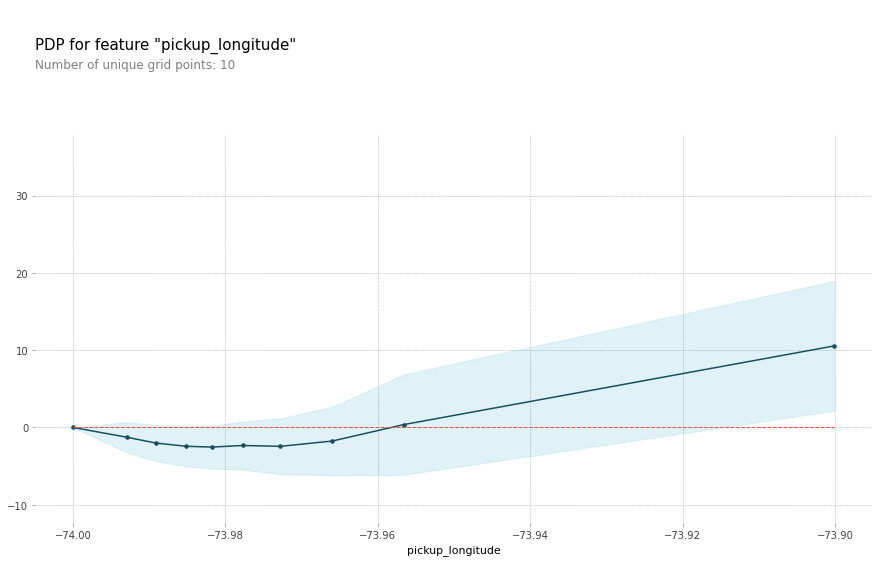

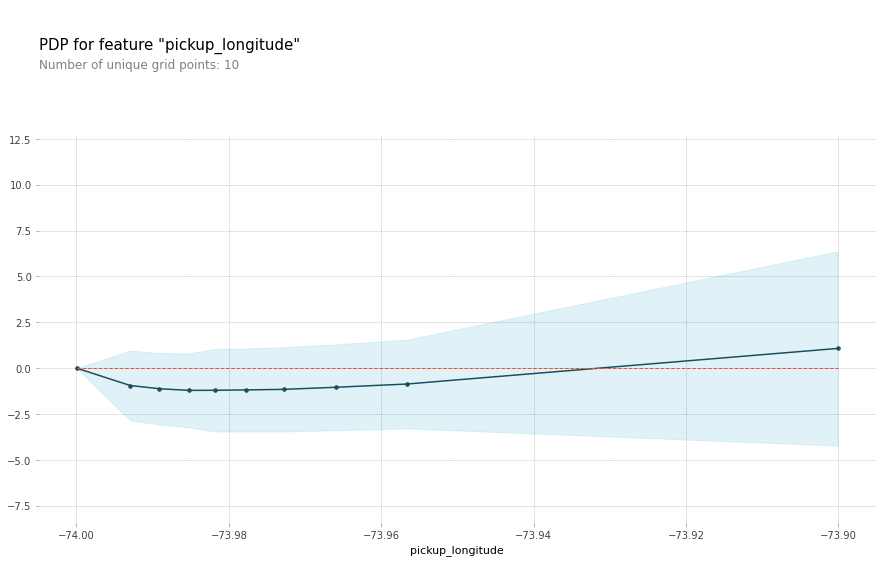

In [ ]:
# This is the PDP for pickup_longitude without the absolute difference features (for easy comparison)
feat_name = 'pickup_longitude'
pdp_dist_original = pdp.pdp_isolate(model=first_model, dataset=X_val, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist_original, feat_name)
plt.show()

# create new features
df['abs_lon_change'] = abs(df.dropoff_longitude - df.pickup_longitude)
df['abs_lat_change'] = abs(df.dropoff_latitude - df.pickup_latitude)

features_2  = ['pickup_longitude',
               'pickup_latitude',
               'dropoff_longitude',
               'dropoff_latitude',
               'abs_lat_change',
               'abs_lon_change']
X = df[features_2]

# Second model with new features
X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X, y, random_state=1)
second_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(X_train_new, y_train_new)

# See PDP for pickup_longitude with abs difference features
feat_name = 'pickup_longitude'
pdp_dist = pdp.pdp_isolate(model=second_model, dataset=X_val_new, model_features=features_2, feature=feat_name)
pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

The partial dependence plot became much smaller in height with the new features. The range between the max and min is about 15 in the top chart, whereas this difference is only about 3 in the bottom chart. In other words, once you control for absolute distance traveled, the `'pickup_longitude'` has only a very small impact on predictions.

***

Consider a scenario where you have only 2 predictive features, which we will call `feat_A` and `feat_B`. Both features have minimum values of -1 and maximum values of 1. The partial dependence plot for `feat_A` increases steeply over its whole range, whereas the partial dependence plot for `feat_B` increases at a slower rate (less steeply) over its whole range.

Does this guarantee that `feat_A` will have a higher permutation importance than `feat_B`. Why or why not?

**No**. This **doesn't guarantee** `feat_A` is more important. For example, `feat_A` could have a big effect in the cases where it varies, but could have a single value 99% of the time. In that case, permuting `feat_A` wouldn't matter much, since most values would be unchanged.

***

Next Exercise:

1. Creates two features, `X1` and `X2`, having random values in the range [-2, 2].
2. Creates a target variable `y`, which is always 1.
3. Trains a `RandomForestRegressor` model to predict `y` given `X1` and `X2`.
4. Creates a PDP plot for `X1` and a scatter plot of `X1` vs. `y`.

Do you have a prediction about what the PDP plot will look like? Run the cell to find out.

Modify the initialization of `y` so that our PDP plot has a positive slope in the range [-1,1], and a negative slope everywhere else. (Note: *you should only modify the creation of `y`, leaving `X1`, `X2`, and `my_model` unchanged.*)

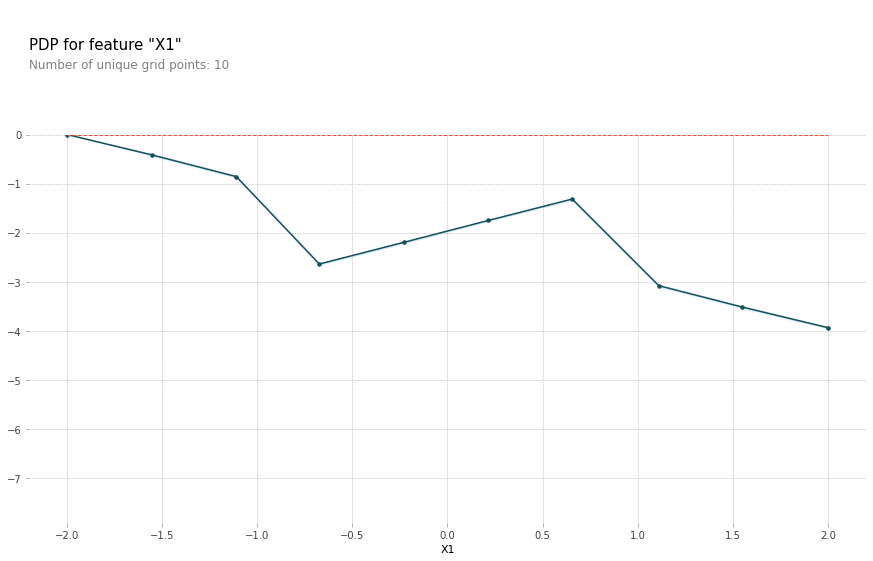

In [ ]:
import numpy as np
from numpy.random import rand

n_samples = 20000

# Create array holding predictive feature
X1 = 4 * rand(n_samples) - 2
X2 = 4 * rand(n_samples) - 2
# Create y. you should have X1 and X2 in the expression for y
y = -2 * X1 * (X1<-1) + X1 - 2 * X1 * (X1>1) - X2


# create dataframe because pdp_isolate expects a dataFrame as an argument
my_df = pd.DataFrame({'X1': X1, 'X2': X2, 'y': y})
predictors_df = my_df.drop(['y'], axis=1)

my_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(predictors_df, my_df.y)

pdp_dist = pdp.pdp_isolate(model=my_model, dataset=my_df, model_features=['X1', 'X2'], feature='X1')

# visualize your results
pdp.pdp_plot(pdp_dist, 'X1')
plt.show()

Create a dataset with 2 features and a target, such that the pdp of the first feature is flat, but its permutation importance is high. We will use a RandomForest for the model.

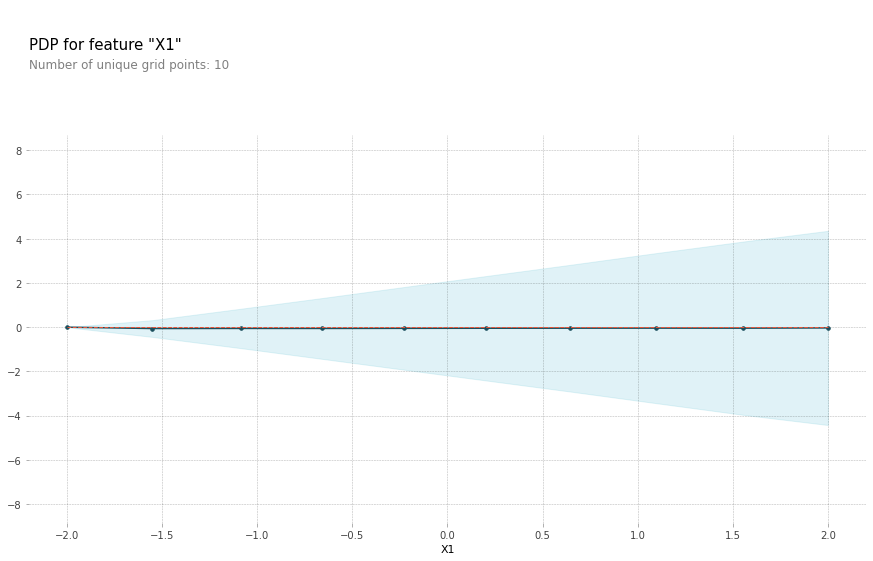

Weight,Feature
2.0104 ± 0.0305,X1
2.0027 ± 0.0427,X2


In [ ]:
n_samples = 20000

# Create array holding predictive feature
X1 = 4 * rand(n_samples) - 2
X2 = 4 * rand(n_samples) - 2
# Create y. you should have X1 and X2 in the expression for y
y = X1 * X2


# create dataframe because pdp_isolate expects a dataFrame as an argument
my_df = pd.DataFrame({'X1': X1, 'X2': X2, 'y': y})
predictors_df = my_df.drop(['y'], axis=1)

my_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(predictors_df, my_df.y)


pdp_dist = pdp.pdp_isolate(model=my_model, dataset=my_df, model_features=['X1', 'X2'], feature='X1')
pdp.pdp_plot(pdp_dist, 'X1')
plt.show()

perm = PermutationImportance(my_model).fit(predictors_df, my_df.y)

# show the weights for the permutation importance you just calculated
eli5.show_weights(perm, feature_names = ['X1', 'X2'])

***
## **SHAP Values**

So far, we've extracted general insights from a ML model but now we want to break down how the model works for an individual prediction.

**SHAP** (SHapley Additive exPlanations) values 
- break down a prediction to show the impact of each feature
- can explain individual predictions but these values can be aggregated into powerful model-level insights as well
- interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value
- great for regular, tabular data

<u>Interpretation</u><br>
The value of the *jth feature* contributed $Φ_j$ to the prediction of this particular instance compared to the average prediction for the dataset.
- $Φ_j$ = SHAP value

***

Using the soccer dataset again to predict whether a team would have a player win the Man of the Match award, we could ask:

How much was a prediction driven by the fact that the team scored **3 goals**, *instead of some baseline* number of goals?

### Process

You decompose a prediction with the following equation:

`sum(SHAP values for all features) = pred_for_team - pred_for_baseline_values`

<u>TLDR</u>:
Shapley Values for a given instance sum to the ***difference*** between the given prediction and the average prediction. SHAP values of all features sum up to explain why my prediction was different from the baseline.

In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML concepts/ML Insights/FIFA 2018 Statistics.csv')

# Define target
y = (df['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
# Get numeric features
feature_names = df.select_dtypes(int).columns.tolist()
# Define inputs
X = df[feature_names]

In [15]:
# Partiiton data
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=1)

# Train model
my_model = RandomForestClassifier(random_state=0).fit(X_train, y_train)

Look at the raw predictions before looking at the SHAP values. See SHAP values for a single row of the dataset (we arbitrarily chose row 5).

In [25]:
# Define single row
row_to_show = 5

data_for_prediction = X_val.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1) # get 2D array for predict_proba

my_model.predict_proba(data_for_prediction_array)

array([[0.29, 0.71]])

The team is 70% likely to have a player win the award.

Now, we'll move onto the code to get SHAP values for that single prediction.

In [28]:
!pip install shap
import shap  # package used to calculate Shap values

In [29]:
# Create object that can calculate shap values (we used TreeExplainer bc our model is rf)
# There are explainers for every type of model
explainer = shap.TreeExplainer(my_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

In [30]:
"""
List of 2 arrays:
- first array = SHAP values for a negative outcome
- second array = SHAP values for the positive outcome
"""

shap_values

[array([-0.10282092,  0.04740467, -0.02983219, -0.02277977, -0.00642731,
        -0.01258714, -0.02910577,  0.00766886, -0.00792221, -0.01031725,
         0.00500036,  0.00094579,  0.02061101, -0.04846459, -0.00601652,
        -0.00042073, -0.0008261 , -0.01286019]),
 array([ 0.10282092, -0.04740467,  0.02983219,  0.02277977,  0.00642731,
         0.01258714,  0.02910577, -0.00766886,  0.00792221,  0.01031725,
        -0.00500036, -0.00094579, -0.02061101,  0.04846459,  0.00601652,
         0.00042073,  0.0008261 ,  0.01286019])]

We typically think about predictions in terms of the prediction of a *positive* outcome, so we'll pull out SHAP values for positive outcomes `shap_values[1]`.

In [34]:
shap.initjs() # load javascript library to see plot
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

Other explainers:
- `shap.DeepExplainer` works with Deep Learning models
- `shap.KernelExplainer` works with all models, though it is slower than other Explainers and it offers an *approximation* rather than exact SHAP values

In [35]:
# use Kernel SHAP to explain test set predictions
k_explainer = shap.KernelExplainer(my_model.predict_proba, X_train)
k_shap_values = k_explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(k_explainer.expected_value[1], k_shap_values[1], data_for_prediction)

You get similar results but these are approximations!

***

### Hospital Readmissions Example

In [36]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML concepts/ML Insights/hospital_train.csv')
df.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_Caucasian,race_AfricanAmerican,gender_Female,age_[70-80),age_[60-70),age_[50-60),age_[80-90),age_[40-50),payer_code_?,payer_code_MC,payer_code_HM,payer_code_SP,payer_code_BC,medical_specialty_?,medical_specialty_InternalMedicine,medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,medical_specialty_Cardiology,diag_1_428,diag_1_414,diag_1_786,diag_2_276,diag_2_428,diag_2_250,diag_2_427,diag_3_250,diag_3_401,diag_3_276,diag_3_428,max_glu_serum_None,A1Cresult_None,metformin_No,repaglinide_No,nateglinide_No,chlorpropamide_No,glimepiride_No,acetohexamide_No,glipizide_No,glyburide_No,tolbutamide_No,pioglitazone_No,rosiglitazone_No,acarbose_No,miglitol_No,troglitazone_No,tolazamide_No,examide_No,citoglipton_No,insulin_No,glyburide-metformin_No,glipizide-metformin_No,glimepiride-pioglitazone_No,metformin-rosiglitazone_No,metformin-pioglitazone_No,change_No,diabetesMed_Yes,readmitted
0,14,41,0,11,0,0,0,6,True,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,0
1,2,30,0,12,0,0,1,9,True,False,True,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,1
2,5,66,0,22,1,0,2,9,True,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,1
3,3,63,0,8,0,0,0,8,True,False,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,1
4,5,40,0,6,0,0,1,9,True,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,0


In [37]:
df.shape

(25000, 65)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 65 columns):
 #   Column                                    Non-Null Count  Dtype
---  ------                                    --------------  -----
 0   time_in_hospital                          25000 non-null  int64
 1   num_lab_procedures                        25000 non-null  int64
 2   num_procedures                            25000 non-null  int64
 3   num_medications                           25000 non-null  int64
 4   number_outpatient                         25000 non-null  int64
 5   number_emergency                          25000 non-null  int64
 6   number_inpatient                          25000 non-null  int64
 7   number_diagnoses                          25000 non-null  int64
 8   race_Caucasian                            25000 non-null  bool 
 9   race_AfricanAmerican                      25000 non-null  bool 
 10  gender_Female                             25000 non-null  

Quick hints at interpreting the field names:

- Your prediction target is `readmitted`
- Columns with the word `diag` indicate the diagnostic code of the illness or illnesses the patient was admitted with. For example, `diag_1_428` means the doctor said their first illness diagnosis is number "428".  What illness does 428 correspond to? You could look it up in a codebook, but without more medical background it wouldn't mean anything to you anyway.
- A column names like `glimepiride_No` mean the patient did not have the medicine `glimepiride`. If this feature had a value of False, then the patient did take the drug `glimepiride`
- Features whose names begin with `medical_specialty` describe the specialty of the doctor seeing the patient. The values in these fields are all `True` or `False`.

In [49]:
# Define target and inputs
X = df.drop(['readmitted'], axis=1)
y = df['readmitted']

# Partition data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
# Train basic model
my_model = RandomForestClassifier(n_estimators=30, random_state=1).fit(X_train, y_train)

In [50]:
# Use permutation importance as a succinct model summary
# A measure of model performance on validation data would be useful here too
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0451 ± 0.0068,number_inpatient
0.0087 ± 0.0046,number_emergency
0.0062 ± 0.0053,number_outpatient
0.0033 ± 0.0016,payer_code_MC
0.0020 ± 0.0016,diag_3_401
0.0016 ± 0.0031,medical_specialty_Emergency/Trauma
0.0014 ± 0.0024,A1Cresult_None
0.0014 ± 0.0021,medical_specialty_Family/GeneralPractice
0.0013 ± 0.0010,diag_2_427
0.0013 ± 0.0011,diag_2_276


It appears `'number_inpatient'` is a really important feature. The doctors would like to know more about that. Create a graph for them that shows how `'number_inpatient'` affects the model's predictions.

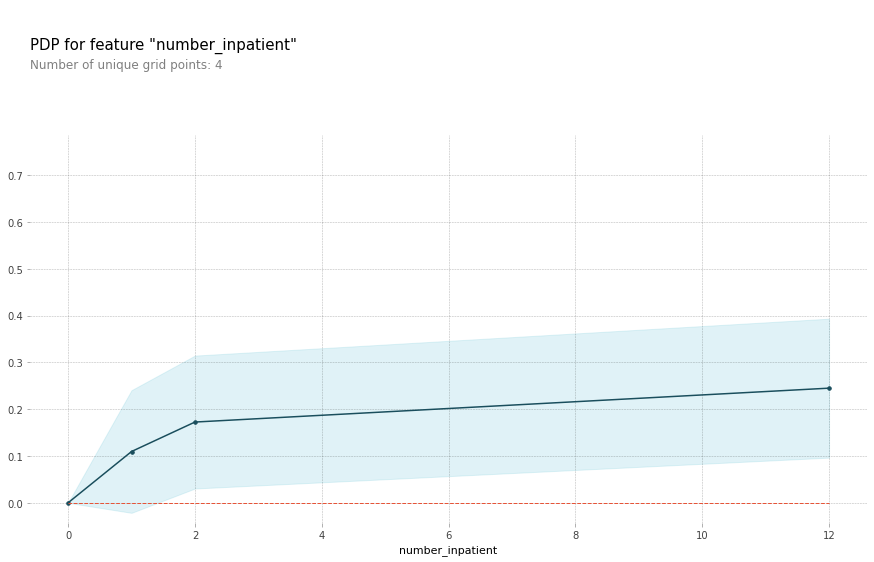

In [60]:
# Calculate and show partial dependence plot
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

feature_name = 'number_inpatient'

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=my_model, dataset=X_test, model_features=X_test.columns, feature=feature_name)

# plot it
pdp.pdp_plot(pdp_goals, feature_name)
plt.show()

The doctors think it's a good sign that increasing the number of inpatient procedures leads to increased predictions. But they can't tell from this plot whether that change in the plot is big or small. They'd like you to create something similar for `'time_in_hospital'` to see how that compares.

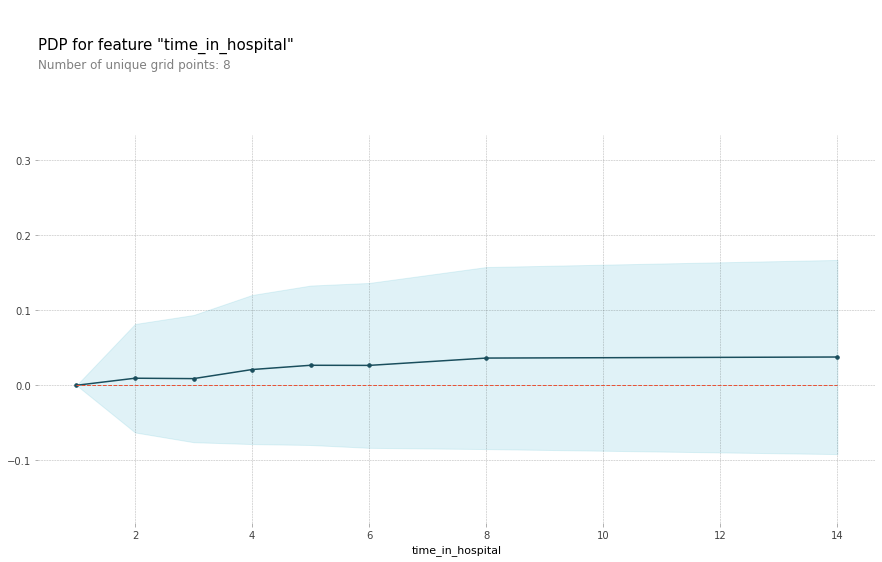

In [61]:
feature_name = 'time_in_hospital'

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=my_model, dataset=X_test, model_features=X_test.columns, feature=feature_name)

# plot it
pdp.pdp_plot(pdp_goals, feature_name)
plt.show()

The results are very different. It seems like `'time_in_hospital'` doesn't matter at all. The difference between the lowest value on the partial dependence plot and the highest value is about 5%.

If that is what your model concluded, the doctors will believe it. But it seems so low. Could the data be wrong, or is your model doing something more complex than they expect?

They'd like you to show them the *raw readmission rate* for each value of `'time_in_hospital'` to see how it compares to the partial dependence plot.

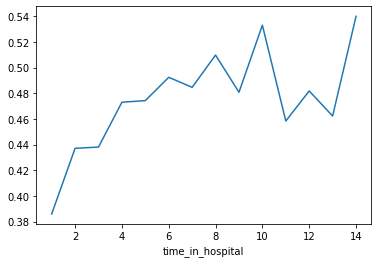

In [66]:
# Get the full training data with the target (no test data)
all_train = pd.concat([X_train, y_train], axis=1)
# Group by time in hospital to get average readmission rate for each time
all_train.groupby(['time_in_hospital']).mean().readmitted.plot()
plt.show()

Now the doctors are convinced you have the right data, and the model overview looked reasonable. It's time to turn this into a finished product they can use. Specifically, the hospital wants you to create a function `patient_risk_factors` that does the following:

Takes a single row with patient data (of the same format you as your raw data)
Creates a visualization showing what features of that patient increased their risk of readmission, what features decreased it, and how much those features mattered.

It's not important to show every feature with every miniscule impact on the readmission risk. It's fine to focus on only the most important features for that patient.

In [68]:
# Use SHAP values to show the effect of each feature of a given patient

import shap  # package used to calculate Shap values

# First row of data to test function
sample_data_for_prediction = X_test.iloc[0].astype(float)

def patient_risk_factors(model, patient_data):
    # Create object that can calculate shap values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patient_data)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient_data)

In [79]:
patient_risk_factors(my_model, sample_data_for_prediction)